### Analysis of Hubway Trip Time to Bike Rentral Request in Boston

This project uses data from the City of Bostom to compare Hubway bike rental metrics (number of bike rentals per hour, rental duration, etc.) against weather data for each of the Hubway station. We set out to achieve the following:

1) Determine if correlations between weather variables (temperarure, humidity, etc.) and Hubway bike rental metrics (number of Hubway bike rental requests, average trip time, number of Hibway bike rental request per hour) exist. Does the Hubway have more registered users than casual users? What variables most influence the number of Hubway bike rental per hour?

2) Determine if there is a statistically significant difference between northern and southern community areas in bike rental duration or the number of number of bike rental per hour. Perform k-means clustering to discover if census data can accurately predict a northern or southern community area.

3) Create regression model using machine learning to predict trip time and number of bike rental per hour given weather data for a particular area. This model could be used to predict the bike demand in the city for any hubway station and provide an estimate of bike inventory to be maintained for any season.

In [1]:
%pylab inline

import re
import numpy as np
import pandas as pd
import time
from time import mktime
from datetime import date, datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
sns.set_style(style='white')
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))

fall


In [3]:
weather = ['Clear', 'Rain', 'Rain , Thunderstorm', 'Fog , Rain',
       'Thunderstorm', 'Fog', 'Fog , Rain , Thunderstorm', 'Rain , Snow',
       'Rain , Hail , Thunderstorm', 'Snow']

def getWeather(event):
    if (event == "Clear" or event == ""):
        return 1
    elif (event == "Rain" or event == "Fog , Rain" or event == 'Fog'):
        return 2
    elif (event == "Rain , Thunderstorm" or event == 'Fog , Rain , Thunderstorm' or event == 'Thunderstorm'):
        return 3
    elif (event == "Snow" or event == 'Rain , Snow' or event == 'Rain , Hail , Thunderstorm'):
        return 4
    else:
        return 1
    
getWeather('Fog , Rain , Thunderstorm')

3

In [4]:
import math

def get_windchill(vTemperature,vWindSpeed,vRelativeHumidity):
    #vTemperature = float(35)
    #vWindSpeed = float(10)
    #vRelativeHumidity = float(72)

    # Try Wind Chill first
    if vTemperature <= 50 and vWindSpeed >= 3:
        vFeelsLike = 35.74 + (0.6215*vTemperature) - 35.75*(vWindSpeed**0.16) + ((0.4275*vTemperature)*(vWindSpeed**0.16))
    else:
        vFeelsLike = vTemperature

    # Replace it with the Heat Index, if necessary
    if vFeelsLike == vTemperature and vTemperature >= 80:
        vFeelsLike = 0.5 * (vTemperature + 61.0 + ((vTemperature-68.0)*1.2) + (vRelativeHumidity*0.094))

        if vFeelsLike >= 80:
            vFeelsLike = -42.379 + 2.04901523*vTemperature + 10.14333127*vRelativeHumidity - .22475541*vTemperature*vRelativeHumidity - .00683783*vTemperature*vTemperature - .05481717*vRelativeHumidity*vRelativeHumidity + .00122874*vTemperature*vTemperature*vRelativeHumidity + .00085282*vTemperature*vRelativeHumidity*vRelativeHumidity - .00000199*vTemperature*vTemperature*vRelativeHumidity*vRelativeHumidity
            if vRelativeHumidity < 13 and vTemperature >= 80 and vTemperature <= 112:
                vFeelsLike = vFeelsLike - ((13-vRelativeHumidity)/4)*math.sqrt((17-math.fabs(vTemperature-95.))/17)
            if vRelativeHumidity > 85 and vTemperature >= 80 and vTemperature <= 87:
                vFeelsLike = vFeelsLike + ((vRelativeHumidity-85)/10) * ((87-vTemperature)/5)
    
    print("Feels like: " + '%0.1f' % (vFeelsLike) + "F")
    return vFeelsLike
    # Feels like: 27.4F

get_windchill(80, 6, 80)

Feels like: 84.2F


84.23041599999999

In [5]:
def getLattitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LAT']]

getLattitude(5)

,LAT
2,42.341814


In [6]:
def getLongitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LNG']]

getLongitude(5)

,LNG
2,-71.090179


In [45]:
def getAge(birth_year):
    now  = datetime.now()
    if birth_year != 0:
        return now.year - birth_year
    else:
        return 0

getAge(1980)

37

In [46]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### Importing Hubway trip data from csv

Link to dataset: http://hubwaydatachallenge.org/trip-history-data/

In [8]:
dfTrips = pd.read_csv('data/hubway_trips.csv',parse_dates=True, index_col='seq_id', na_values={''})

dfTrips.columns = ['HID','STATUS','DURATION','START_DATE','START_STATION','END_DATE',
                   'END_STATION','BIKE_NO','SUB_TYPE','ZIPCODE','BIRTH_DATE','GENDER']

#### Cleaning the dataset

In [9]:
df = dfTrips.copy()

#Convert completion date from string to datetime object
cleanedStartDate = []
for date in df['START_DATE']:
    if date != None:
        cleanedStartDate.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    else:
        cleanedStartDate.append(None)

df.insert(1, 'CLEAN_START_DATE', cleanedStartDate)
df.insert(2, 'DATE', df['CLEAN_START_DATE'].apply(lambda x: x.date()))

df3 = pd.pivot_table(df, index=['DATE'], values='DURATION', aggfunc=np.mean)
df4 = pd.pivot_table(df, index=['DATE'], columns=["SUB_TYPE"], values='HID', aggfunc='count')

df5 = pd.DataFrame(df3.to_records())
df6 = pd.DataFrame(df4.to_records())

print(df5.head(5))
print(df6.head(5))

         DATE     DURATION
0  2011-07-28  2043.235849
1  2011-07-29  2424.777985
2  2011-07-30  4269.618750
3  2011-07-31  4698.158888
4  2011-08-01  3066.998731
         DATE  Casual  Registered
0  2011-07-28   198.0       226.0
1  2011-07-29   341.0       195.0
2  2011-07-30   697.0       103.0
3  2011-07-31   904.0       103.0
4  2011-08-01   539.0       249.0


#### Importing Daily Weather Data from csv

In [10]:
dfWeather = pd.read_csv('data/weather.csv',parse_dates=True)

dfWeather.columns = ['CDATE','YEAR','MONTH','DAY','THIGH','TAVG','TLOW','DHIGH','DAVG',
                     'DLOW','HHIGH','HAVG','HLOW','PHIGH','PAVG','PLOW','VHIGH','VAVG',
                     'VLOW','WHIGH','WAVG','WLOW','PRECIP','EVENT']

#### Cleaning the dataset

In [11]:
df2 = dfWeather.copy()

cleanedDate = []
for date in df2['CDATE']:
    if date != None:
        cleanedDate.append(datetime.strptime(date, '%m/%d/%Y'))
    else:
        cleanedDate.append(None)

df2.insert(1, 'DATE', cleanedDate)
df2['DATE'] = df2['DATE'].apply(lambda x: x.date())

df2[['EVENT']] = df2[['EVENT']].fillna(value='Clear')
df2['PRECIP']  = pd.to_numeric(df2['PRECIP'], errors='ignore')
df2['PRECIP']  = df2['PRECIP'].str.replace('T', '0').astype(np.float64)
#df2.insert(2, 'WEATHER', df2['EVENT'].map(getWeather))

del df2['YEAR'], df2['MONTH'], df2['DAY'], df2['THIGH'], df2['TLOW'], df2['DHIGH']
del df2['DLOW'], df2['HHIGH'], df2['HLOW'], df2['PHIGH'], df2['PLOW'], df2['VHIGH']
del df2['VLOW'], df2['WHIGH'], df2['WLOW'], df2['CDATE']

df2.head()

,DATE,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP,EVENT
0,2011-01-01,46,37,73,30.04,9,6,0.00,Clear
1,2011-01-02,45,41,85,29.88,5,7,0.15,Rain
2,2011-01-03,34,12,48,29.98,10,15,0.00,Clear
3,2011-01-04,32,16,52,29.89,10,10,0.00,Clear
4,2011-01-05,34,15,49,29.73,10,12,0.00,Clear


In [12]:
import calendar

dfDailyRental = pd.merge(df6, df2, on='DATE')
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dfDailyRental['DATE'].min(), end=dfDailyRental['DATE'].max()).to_pydatetime()

dfDailyRental['HOLIDAY'] = dfDailyRental['DATE'].isin(holidays).astype(int)
dfDailyRental['WORKDAY'] = ((pd.DatetimeIndex(dfDailyRental['DATE']).dayofweek) // 5 == 1).astype(int)
dfDailyRental.insert(12, 'SEASON', dfDailyRental['DATE'].map(get_season))
dfDailyRental.insert(5, 'WEEKDAY', pd.to_datetime(dfDailyRental['DATE']).dt.weekday_name)
dfDailyRental.insert(7, 'MONTH', pd.to_datetime(dfDailyRental['DATE']).dt.month)
dfDailyRental['MONTH'] = dfDailyRental['MONTH'].apply(lambda x: calendar.month_abbr[x])
dfDailyRental['Casual'] = dfDailyRental['Casual'].fillna(0)
dfDailyRental['TOTAL'] = dfDailyRental['Casual'] + dfDailyRental['Registered']

cols = ['DATE','SEASON','WEEKDAY','MONTH','HOLIDAY','WORKDAY','EVENT','TAVG','DAVG',
        'HAVG','PAVG','VAVG','WAVG','PRECIP','Casual','Registered','TOTAL']

dfDailyRental = dfDailyRental[cols]
dfDailyRental = dfDailyRental.rename(columns = {'Casual':'CASUAL', 'Registered':'REGISTERED'})

##### Shape Of The Dataset

In [13]:
dfDailyRental.shape

(628, 17)

##### Sample Of First Few Rows

In [14]:
dfDailyRental.head(2)

,DATE,SEASON,WEEKDAY,MONTH,HOLIDAY,WORKDAY,EVENT,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP,CASUAL,REGISTERED,TOTAL
0,2011-07-28,summer,Thursday,Jul,0,0,Clear,72,62,73,30.04,10,9,0.00,198.0,226.0,424.0
1,2011-07-29,summer,Friday,Jul,0,0,Rain,73,67,81,29.91,9,8,0.14,341.0,195.0,536.0


##### Variables Data Type

In [15]:
dfDailyRental.dtypes

DATE           object
SEASON         object
WEEKDAY        object
MONTH          object
HOLIDAY         int64
WORKDAY         int64
EVENT          object
TAVG            int64
DAVG            int64
HAVG            int64
PAVG          float64
VAVG            int64
WAVG            int64
PRECIP        float64
CASUAL        float64
REGISTERED    float64
TOTAL         float64
dtype: object

In [16]:
categoryVariableList = ["WEEKDAY","MONTH","SEASON","EVENT","HOLIDAY","WORKDAY"]
for var in categoryVariableList:
    dfDailyRental[var] = dfDailyRental[var].astype("category")

##### Dropping Unncessary Columns

In [17]:
# dfDailyRental  = dfDailyRental.drop(["DATE"],axis=1)

##### Lets Start With Very Simple Visualization Of Variables DataType Count

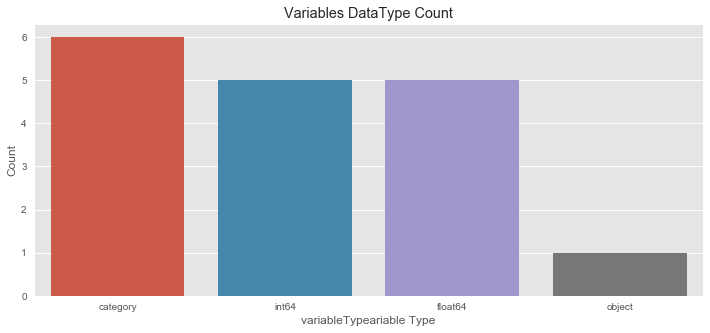

In [18]:
dataTypeDf = pd.DataFrame(dfDailyRental.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

##### Missing Values Analysis

In [19]:
null_data = dfDailyRental[dfDailyRental.isnull().any(axis=1)]
print(null_data.count)

<bound method DataFrame.count of Empty DataFrame
Columns: [DATE, SEASON, WEEKDAY, MONTH, HOLIDAY, WORKDAY, EVENT, TAVG, DAVG, HAVG, PAVG, VAVG, WAVG, PRECIP, CASUAL, REGISTERED, TOTAL]
Index: []>


##### Skewness In Distribution

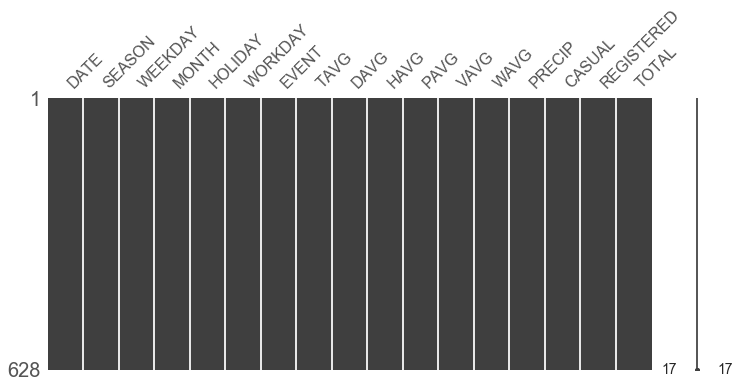

In [20]:
import missingno as msno
msno.matrix(dfDailyRental,figsize=(12,5))

#### Outliers Analysis

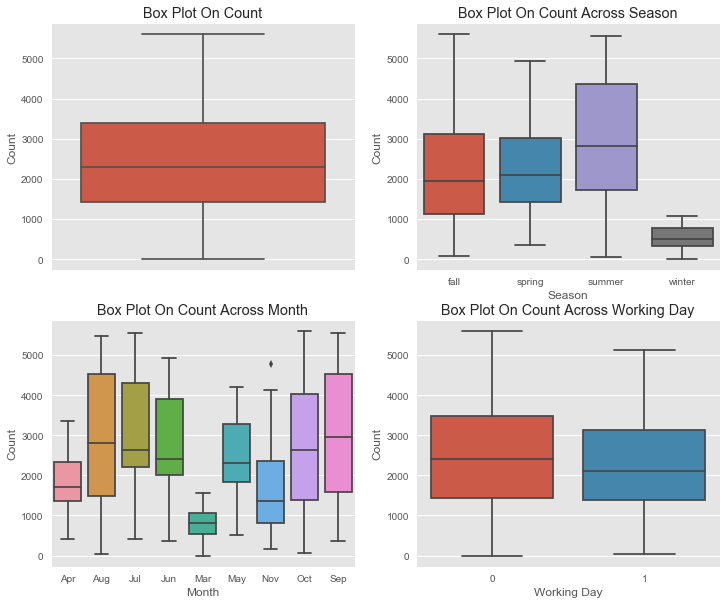

In [21]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=dfDailyRental,y="TOTAL",orient="v",ax=axes[0][0])
sns.boxplot(data=dfDailyRental,y="TOTAL",x="SEASON",orient="v",ax=axes[0][1])
sns.boxplot(data=dfDailyRental,y="TOTAL",x="MONTH",orient="v",ax=axes[1][0])
sns.boxplot(data=dfDailyRental,y="TOTAL",x="WORKDAY",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Month")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

##### Correlation Analysis

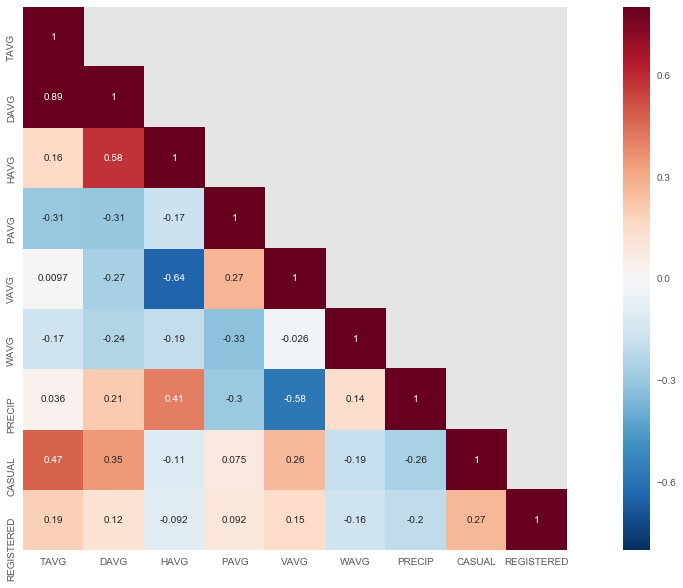

In [22]:
corrMatt = dfDailyRental[["TAVG","DAVG","HAVG","PAVG","VAVG","WAVG","PRECIP","CASUAL","REGISTERED"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

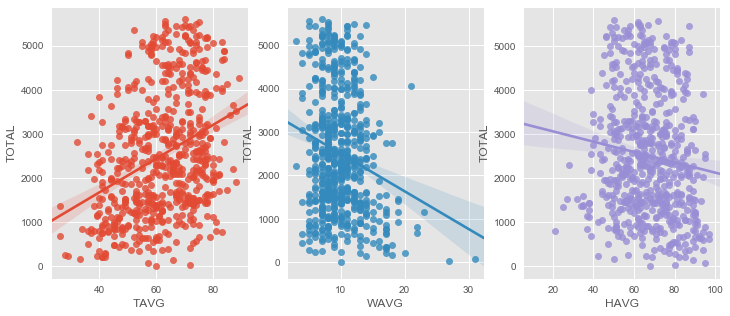

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="TAVG", y="TOTAL", data=dfDailyRental,ax=ax1)
sns.regplot(x="WAVG", y="TOTAL", data=dfDailyRental,ax=ax2)
sns.regplot(x="HAVG", y="TOTAL", data=dfDailyRental,ax=ax3)

##### Visualizing Distribution Of Data

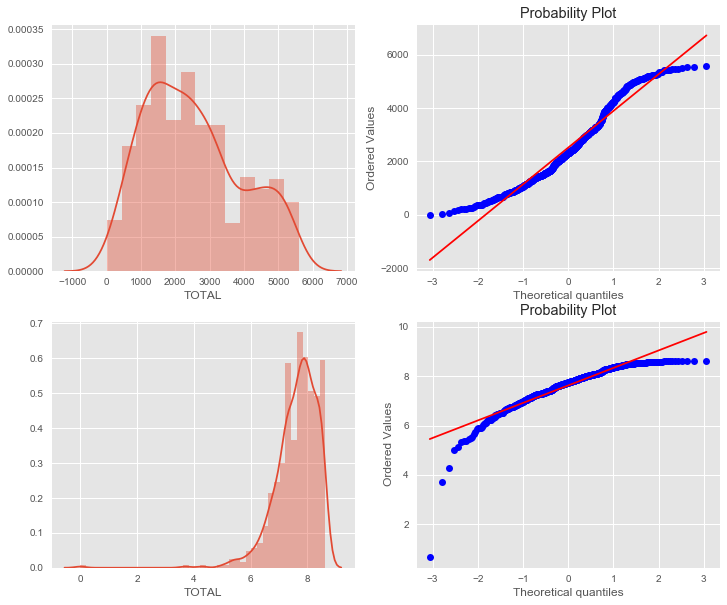

In [24]:
from scipy import stats

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(dfDailyRental["TOTAL"],ax=axes[0][0])
stats.probplot(dfDailyRental["TOTAL"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dfDailyRental["TOTAL"]),ax=axes[1][0])
stats.probplot(np.log1p(dfDailyRental["TOTAL"]), dist='norm', fit=True, plot=axes[1][1])
plt.show()

##### Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

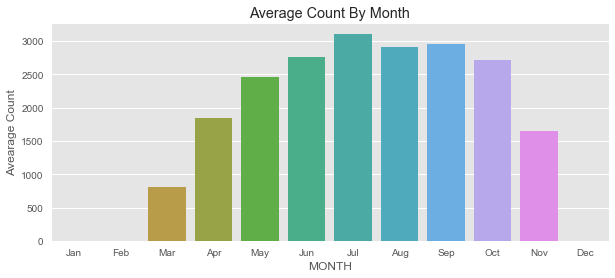

In [25]:
fig,ax1 = plt.subplots()
fig.set_size_inches(10,4)
sortOrder = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dfDailyRental.groupby("MONTH")["TOTAL"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="TOTAL",ascending=False)
sns.barplot(data=monthSorted,x="MONTH",y="TOTAL",ax=ax1,order=sortOrder)
ax1.set(xlabel='MONTH', ylabel='Avearage Count',title="Average Count By Month")

plt.show()

In [26]:
dropFeatures = ['CASUAL',"TOTAL","DATE","REGISTERED"]
dfDaily  = dfDailyRental.drop(dropFeatures,axis=1)

In [28]:
dfDaily.head(5)

,SEASON,WEEKDAY,MONTH,HOLIDAY,WORKDAY,EVENT,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP
0,summer,Thursday,Jul,0,0,Clear,72,62,73,30.04,10,9,0.00
1,summer,Friday,Jul,0,0,Rain,73,67,81,29.91,9,8,0.14
2,summer,Saturday,Jul,0,1,Clear,81,64,65,29.82,9,12,0.00
3,summer,Sunday,Jul,0,1,Clear,81,58,51,29.99,10,9,0.00
4,summer,Monday,Aug,0,0,Clear,83,64,53,29.82,10,8,0.00


In [29]:
features_df = pd.get_dummies(dfDaily, columns=['SEASON','WEEKDAY','MONTH','EVENT'])

In [36]:
features_df.head(5)

,HOLIDAY,WORKDAY,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP,SEASON_fall,...,EVENT_Clear,EVENT_Fog,"EVENT_Fog , Rain","EVENT_Fog , Rain , Thunderstorm",EVENT_Rain,"EVENT_Rain , Hail , Thunderstorm","EVENT_Rain , Snow","EVENT_Rain , Thunderstorm",EVENT_Snow,EVENT_Thunderstorm
0,0,0,72,62,73,30.04,10,9,0.00,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,73,67,81,29.91,9,8,0.14,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,81,64,65,29.82,9,12,0.00,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,81,58,51,29.99,10,9,0.00,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,83,64,53,29.82,10,8,0.00,0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
dataTrain = features_df
yLabels = dfDailyRental['TOTAL']

##### Linear Regression Model

In [47]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.566671583213


##### Ensemble Models - Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.227884366159


##### Ensemble Model - Gradient Boost

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=400,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.216821765312
